In [ ]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from modules import faker
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
import arviz as az
from typing import List
from collections import Counter
import pandas as pd
import hvplot.pandas
import holoviews as hv
from holoviews import opts

/Users/tjpajala/anaconda3/envs/rethink/lib/python3.9/site-packages/colorcet/__init__.py:74: UserWarning: Trying to register the cmap 'cet_gray' which already exists.
  register_cmap("cet_"+name, cmap=cm[name])
/Users/tjpajala/anaconda3/envs/rethink/lib/python3.9/site-packages/colorcet/__init__.py:74: UserWarning: Trying to register the cmap 'cet_gray_r' which already exists.
  register_cmap("cet_"+name, cmap=cm[name])


Load data with the faker module.

In [ ]:
n_resp = 1000
prob_b = 0.6
prob_a = 1 - prob_b
results = faker.create_fake_ab_test_results(n=n_resp, prob_a=prob_a)

Inspect the results

In [ ]:
print(results["person"][0:5])
print(results["choice"][0:10])


Define prior for the `prob_a`

In [ ]:
prior_p = dist.Uniform(0,1)

Solve analytically for each observation:


In [ ]:
sum(results["choice"])

In [ ]:
W = sum(results["choice"])
print("Number of 0s (A) in data: {}".format(W))
L = len(results["choice"]) - W
print("Number of 0s (B) in data: {}".format(L))
x = jnp.linspace(0, 1, 101)
#jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x))
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)))

Set bounds for how sure you want to be about the result that A is better to break test.

In [ ]:
desired_certainty = 0.95
prior = dist.Beta(2,2)
#prior=dist.Uniform(0,1)

In [ ]:
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(prior.log_prob(x)), "--")

In [ ]:
def model(W, L, prior):
    p = numpyro.sample("p", prior)  # prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood

L = 4
#print("Number of 0s (A) in data: {}".format(W))
W = 6
#print("Number of 0s (B) in data: {}".format(L))
#print("Distribution of seen data:{}".format(Counter(true_results["choice"][0:i])))
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=W, L=L, prior=prior)
params, losses = svi.run(random.PRNGKey(0), 1000, progress_bar=False)

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (10000,))
numpyro.diagnostics.print_summary(samples, prob=desired_certainty, group_by_chain=False)

Note that in this special beta-binomial case, we can also compute the posterior analytically!

In [ ]:
s_beta = dist.Beta(W+1, L+1).sample(random.PRNGKey(1), (10000,))
print("mean {:.2f}, std {:.2f}, median {:.2f}, 2.5% {:.2f}, 97.5% {:.2f}".format(
np.mean(s_beta), np.std(s_beta), np.median(s_beta), np.percentile(s_beta, 2.5), np.percentile(s_beta, 97.5)))

In [ ]:
numpyro.diagnostics.hpdi(s_beta, prob=desired_certainty)

In [ ]:
def sim_single_experiment(desired_certainty: float, true_results: dict, true_probs_a: List[float],
                         min_n_obs: int =10, inference_strategy="analytical") -> pd.DataFrame:
    experiment_length = len(results["choice"])
    res = pd.DataFrame()
    res["hpdi_lower"] = [np.nan] * experiment_length
    res["hpdi_upper"] = [np.nan] * experiment_length
    res["n"] = [np.nan] * experiment_length
    for true_prob_a in true_probs_a:
        print("Running experiment with true_prob_a: {}, desired_certainty {}\n".format(true_prob_a, desired_certainty))

            
        samples, hpdi = [run_inference(i, true_results, inference_strategy) for i in range(len(experiment_length))]


        res["hpdi_lower"] = [x[0] for x in hpdi]
        res["hpdi_upper"] = [x[1] for x in hpdi]
        res["n"] = range(len(samples))
        res["desired_certainty"] = desired_certainty
        res["true_prob_a"] = true_prob_a

        for i in range(0,experiment_length,10):
            if i == 0:
                continue
            if i >= min_n_obs:
                hpdi = (res["hpdi_lower"][i], res["hpdi_upper"][i])
                print("With {} obs {}, {:.0%} HPDI is {:.3f} - {:.3f}".format(i, dict(Counter(true_results["choice"][0:i])),
                                                                              desired_certainty, hpdi[0],hpdi[1]))
                if hpdi[0] > 0.5:
                    print("HPDI lower bound is bigger than 0.5, so we are at least {} sure A is better!".format(desired_certainty))
                    print("Breaking at {} obs.\n".format(i))
                    #az.plot_density({"p": samples["p"]}, hdi_prob=1, shade=0.5)
                    break
                if hpdi[1] < 0.5:
                    print("HPDI upper bound is smaller than 0.5, so we are at least {} sure B is better!".format(desired_certainty))
                    print("Breaking at {} obs.\n".format(i))
                    break
                #print("Not sure enough about the result, continue study...\n")
    return res
def run_inference(i, true_results, inference_strategy):
    L = sum(true_results["choice"][0:i])
    #print("Number of 0s (A) in data: {}".format(W))
    W = len(true_results["choice"][0:i]) - L
    #print("Number of 0s (B) in data: {}".format(L))
    #print("Distribution of seen data:{}".format(Counter(true_results["choice"][0:i])))
    if inference_strategy == "svi":
        def model(W, L):
            p = numpyro.sample("p", prior)  # prior
            numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood
        guide = AutoLaplaceApproximation(model)
        svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=W, L=L, prior=dist.Beta(1,1))
        params, losses = svi.run(random.PRNGKey(0), 1000, progress_bar=False)

        # display summary of quadratic approximation
        samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
    if inference_strategy == "analytical":
                prior = 1
                samples = dict()
                samples["p"] = dist.Beta(W+prior, L+prior).sample(random.PRNGKey(1), (1000,))
    hpdi=[numpyro.diagnostics.hpdi(s,prob=desired_certainty) for s in samples["p"]]
    return samples, hpdi
#numpyro.diagnostics.print_summary(samples, prob=desired_certainty, group_by_chain=False)
#az.plot_density({"p": samples["p"]}, hdi_prob=1, shade=0.5)
#plt.show()
return samples

In [ ]:
res = sim_single_experiment(desired_certainty, results, true_probs_a=[0.6])

In [ ]:
res.hvplot.line(x="n", 
                y=["hpdi_lower","hpdi_upper","true_prob_a"]) * \
    hv.HLine(0.5).opts(
    opts.HLine(color='blue', line_width=1, line_dash="dashed"))

In [ ]:
def sim_many_experiments(n_exp: int, true_probs_a: List[float], 
                         desired_cert_list: List[float], n_resp: int =1000) -> pd.DataFrame:
    all_res = None
    for prob_a in true_probs_a:
        for cert in desired_cert_list:
            for experiment in range(n_exp):
                print("Creating fake data for experiment {}, true_prob {}, desired cert {}, n_obs {}".format(experiment + 1,
                                                                                                  prob_a, cert, n_resp))
                sim_data = faker.create_fake_ab_test_results(n=n_resp, prob_a=prob_a)
                single_res = sim_single_experiment(cert, sim_data, true_probs_a=[prob_a]).dropna(axis=0, how="any").tail(1)
                print(single_res)
                if all_res is None:
                    all_res = single_res.copy()
                    del single_res
                else:
                    all_res = pd.merge(all_res, single_res, how="outer")
                print("all_res {} rows\n".format(len(all_res)))
    return all_res

In [ ]:
res = sim_single_experiment(desired_certainty, results, true_probs_a=[0.6])

In [ ]:
numpyro.diagnostics.hpdi(s_beta, prob=desired_certainty)

In [ ]:
def sim_single_experiment(desired_certainty: float, true_results: dict, true_probs_a: List[float],
                         min_n_obs: int =10, inference_strategy="analytical") -> pd.DataFrame:
    experiment_length = len(results["choice"])
    res = pd.DataFrame()
    res["hpdi_lower"] = [np.nan] * experiment_length
    res["hpdi_upper"] = [np.nan] * experiment_length
    res["n"] = [np.nan] * experiment_length
    for true_prob_a in true_probs_a:
        print("Running experiment with true_prob_a: {}, desired_certainty {}\n".format(true_prob_a, desired_certainty))
        for i in range(experiment_length):
            if i == 0:
                continue
            
            L = sum(true_results["choice"][0:i])
            #print("Number of 0s (A) in data: {}".format(W))
            W = len(true_results["choice"][0:i]) - L
            #print("Number of 0s (B) in data: {}".format(L))
            #print("Distribution of seen data:{}".format(Counter(true_results["choice"][0:i])))
            if inference_strategy == "svi":
                def model(W, L, prior):
                    p = numpyro.sample("p", prior)  # prior
                    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood
                guide = AutoLaplaceApproximation(model)
                svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=W, L=L, prior=prior)
                params, losses = svi.run(random.PRNGKey(0), 1000, progress_bar=False)

                # display summary of quadratic approximation
                samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
            if inference_strategy == "analytical":
                prior = 1
                samples = dict()
                samples["p"] = dist.Beta(W+prior, L+prior).sample(random.PRNGKey(1), (1000,))
            #numpyro.diagnostics.print_summary(samples, prob=desired_certainty, group_by_chain=False)
            #az.plot_density({"p": samples["p"]}, hdi_prob=1, shade=0.5)
            #plt.show()
            
            hpdi=numpyro.diagnostics.hpdi(samples["p"],prob=desired_certainty)
            res["hpdi_lower"][i] = hpdi[0]
            res["hpdi_upper"][i] = hpdi[1]
            res["n"][i] = i
            res["desired_certainty"] = desired_certainty
            res["true_prob_a"] = true_prob_a
            if i >= min_n_obs:
                print("With {} obs {}, {:.0%} HPDI is {:.3f} - {:.3f}".format(i, dict(Counter(true_results["choice"][0:i])),
                                                                              desired_certainty, hpdi[0],hpdi[1]))
                if hpdi[0] > 0.5:
                    print("HPDI lower bound is bigger than 0.5, so we are at least {} sure A is better!".format(desired_certainty))
                    print("Breaking at {} obs.\n".format(i))
                    #az.plot_density({"p": samples["p"]}, hdi_prob=1, shade=0.5)
                    break
                if hpdi[1] < 0.5:
                    print("HPDI upper bound is smaller than 0.5, so we are at least {} sure B is better!".format(desired_certainty))
                    print("Breaking at {} obs.\n".format(i))
                    break
                #print("Not sure enough about the result, continue study...\n")
    return res

In [ ]:
res = sim_single_experiment(desired_certainty, results, true_probs_a=[0.6])

In [ ]:
res.hvplot.line(x="n", 
                y=["hpdi_lower","hpdi_upper","true_prob_a"]) * \
    hv.HLine(0.5).opts(
    opts.HLine(color='blue', line_width=1, line_dash="dashed"))

In [ ]:
def sim_many_experiments(n_exp: int, true_probs_a: List[float], 
                         desired_cert_list: List[float], n_resp: int =1000) -> pd.DataFrame:
    all_res = None
    for prob_a in true_probs_a:
        for cert in desired_cert_list:
            for experiment in range(n_exp):
                print("Creating fake data for experiment {}, true_prob {}, desired cert {}, n_obs {}".format(experiment + 1,
                                                                                                  prob_a, cert, n_resp))
                sim_data = faker.create_fake_ab_test_results(n=n_resp, prob_a=prob_a)
                single_res = sim_single_experiment(cert, sim_data, true_probs_a=[prob_a]).dropna(axis=0, how="any").tail(1)
                print(single_res)
                if all_res is None:
                    all_res = single_res.copy()
                    del single_res
                else:
                    all_res = pd.merge(all_res, single_res, how="outer")
                print("all_res {} rows\n".format(len(all_res)))
    return all_res

In [ ]:
res = sim_single_experiment(desired_certainty, results, true_probs_a=[0.6])

In [ ]:
res.hvplot.line(x="n", 
                y=["hpdi_lower","hpdi_upper","true_prob_a"]) * \
    hv.HLine(0.5).opts(
    opts.HLine(color='blue', line_width=1, line_dash="dashed"))

In [45]:
def sim_many_experiments(n_exp: int, true_probs_a: List[float], 
                         desired_cert_list: List[float], n_resp: int =1000) -> pd.DataFrame:
    all_res = None
    for prob_a in true_probs_a:
        for cert in desired_cert_list:
            for experiment in range(n_exp):
                print("Creating fake data for experiment {}, true_prob {}, desired cert {}, n_obs {}".format(experiment + 1,
                                                                                                  prob_a, cert, n_resp))
                sim_data = faker.create_fake_ab_test_results(n=n_resp, prob_a=prob_a)
                single_res = sim_single_experiment(cert, sim_data, true_probs_a=[prob_a]).dropna(axis=0, how="any").tail(1)
                print(single_res)
                if all_res is None:
                    all_res = single_res.copy()
                    del single_res
                else:
                    all_res = pd.merge(all_res, single_res, how="outer")
                print("all_res {} rows\n".format(len(all_res)))
    return all_res

Creating fake data for experiment 1, true_prob 0.6, desired cert 0.8, n_obs 1000
Running experiment with true_prob_a: 0.6, desired_certainty 0.8

With 1 obs Counter({1: 1}), 80% HPDI is 0.027 - 0.579
With 2 obs Counter({1: 1, 0: 1}), 80% HPDI is 0.242 - 0.801
With 3 obs Counter({1: 2, 0: 1}), 80% HPDI is 0.115 - 0.615
With 4 obs Counter({1: 3, 0: 1}), 80% HPDI is 0.096 - 0.534
With 5 obs Counter({1: 3, 0: 2}), 80% HPDI is 0.216 - 0.657
With 6 obs Counter({1: 3, 0: 3}), 80% HPDI is 0.297 - 0.715
With 7 obs Counter({1: 4, 0: 3}), 80% HPDI is 0.249 - 0.646
With 8 obs Counter({1: 5, 0: 3}), 80% HPDI is 0.222 - 0.595
With 9 obs Counter({1: 6, 0: 3}), 80% HPDI is 0.180 - 0.531
With 10 obs Counter({1: 6, 0: 4}), 80% HPDI is 0.249 - 0.594
With 11 obs Counter({1: 6, 0: 5}), 80% HPDI is 0.303 - 0.639
With 12 obs Counter({1: 6, 0: 6}), 80% HPDI is 0.342 - 0.667
With 13 obs Counter({0: 7, 1: 6}), 80% HPDI is 0.388 - 0.701
With 14 obs Counter({0: 8, 1: 6}), 80% HPDI is 0.420 - 0.722
With 15 obs Cou

With 66 obs Counter({1: 34, 0: 32}), 90% HPDI is 0.379 - 0.572
With 67 obs Counter({1: 34, 0: 33}), 90% HPDI is 0.387 - 0.578
With 68 obs Counter({0: 34, 1: 34}), 90% HPDI is 0.395 - 0.585
With 69 obs Counter({1: 35, 0: 34}), 90% HPDI is 0.389 - 0.577
With 70 obs Counter({0: 35, 1: 35}), 90% HPDI is 0.396 - 0.584
With 71 obs Counter({0: 36, 1: 35}), 90% HPDI is 0.404 - 0.590
With 72 obs Counter({0: 36, 1: 36}), 90% HPDI is 0.398 - 0.582
With 73 obs Counter({1: 37, 0: 36}), 90% HPDI is 0.392 - 0.575
With 74 obs Counter({0: 37, 1: 37}), 90% HPDI is 0.399 - 0.581
With 75 obs Counter({1: 38, 0: 37}), 90% HPDI is 0.393 - 0.575
With 76 obs Counter({0: 38, 1: 38}), 90% HPDI is 0.400 - 0.580
With 77 obs Counter({1: 39, 0: 38}), 90% HPDI is 0.395 - 0.574
With 78 obs Counter({1: 40, 0: 38}), 90% HPDI is 0.389 - 0.567
With 79 obs Counter({1: 41, 0: 38}), 90% HPDI is 0.384 - 0.561
With 80 obs Counter({1: 41, 0: 39}), 90% HPDI is 0.391 - 0.566
With 81 obs Counter({1: 42, 0: 39}), 90% HPDI is 0.386 

With 195 obs Counter({0: 104, 1: 91}), 90% HPDI is 0.470 - 0.584
With 196 obs Counter({0: 105, 1: 91}), 90% HPDI is 0.472 - 0.586
With 197 obs Counter({0: 105, 1: 92}), 90% HPDI is 0.470 - 0.583
With 198 obs Counter({0: 106, 1: 92}), 90% HPDI is 0.472 - 0.585
With 199 obs Counter({0: 107, 1: 92}), 90% HPDI is 0.475 - 0.588
With 200 obs Counter({0: 108, 1: 92}), 90% HPDI is 0.477 - 0.590
With 201 obs Counter({0: 109, 1: 92}), 90% HPDI is 0.479 - 0.592
With 202 obs Counter({0: 109, 1: 93}), 90% HPDI is 0.477 - 0.589
With 203 obs Counter({0: 109, 1: 94}), 90% HPDI is 0.475 - 0.586
With 204 obs Counter({0: 110, 1: 94}), 90% HPDI is 0.477 - 0.588
With 205 obs Counter({0: 110, 1: 95}), 90% HPDI is 0.474 - 0.586
With 206 obs Counter({0: 110, 1: 96}), 90% HPDI is 0.472 - 0.583
With 207 obs Counter({0: 110, 1: 97}), 90% HPDI is 0.470 - 0.580
With 208 obs Counter({0: 111, 1: 97}), 90% HPDI is 0.472 - 0.583
With 209 obs Counter({0: 111, 1: 98}), 90% HPDI is 0.470 - 0.580
With 210 obs Counter({0: 

With 4 obs Counter({0: 4}), 90% HPDI is 0.528 - 0.996
HPDI lower bound is bigger than 0.5, so we are at least 0.9 sure A is better!
Breaking at 4 obs.

   hpdi_lower  hpdi_upper    n  desired_certainty  true_prob_a
4    0.528095    0.995937  4.0                0.9          0.6
all_res 7 rows
Creating fake data for experiment 5, true_prob 0.6, desired cert 0.9, n_obs 1000
Running experiment with true_prob_a: 0.6, desired_certainty 0.9

With 1 obs Counter({0: 1}), 90% HPDI is 0.232 - 0.942
With 2 obs Counter({0: 2}), 90% HPDI is 0.372 - 0.983
With 3 obs Counter({0: 3}), 90% HPDI is 0.465 - 0.995
With 4 obs Counter({0: 4}), 90% HPDI is 0.528 - 0.996
HPDI lower bound is bigger than 0.5, so we are at least 0.9 sure A is better!
Breaking at 4 obs.

   hpdi_lower  hpdi_upper    n  desired_certainty  true_prob_a
4    0.528095    0.995937  4.0                0.9          0.6
all_res 7 rows
Creating fake data for experiment 1, true_prob 0.6, desired cert 0.95, n_obs 1000
Running experiment with 

With 116 obs Counter({0: 63, 1: 53}), 95% HPDI is 0.444 - 0.618
With 117 obs Counter({0: 63, 1: 54}), 95% HPDI is 0.440 - 0.614
With 118 obs Counter({0: 64, 1: 54}), 95% HPDI is 0.444 - 0.617
With 119 obs Counter({0: 64, 1: 55}), 95% HPDI is 0.440 - 0.613
With 120 obs Counter({0: 64, 1: 56}), 95% HPDI is 0.436 - 0.608
With 121 obs Counter({0: 65, 1: 56}), 95% HPDI is 0.440 - 0.611
With 122 obs Counter({0: 66, 1: 56}), 95% HPDI is 0.444 - 0.615
With 123 obs Counter({0: 67, 1: 56}), 95% HPDI is 0.448 - 0.618
With 124 obs Counter({0: 68, 1: 56}), 95% HPDI is 0.452 - 0.621
With 125 obs Counter({0: 69, 1: 56}), 95% HPDI is 0.456 - 0.624
With 126 obs Counter({0: 70, 1: 56}), 95% HPDI is 0.460 - 0.627
With 127 obs Counter({0: 71, 1: 56}), 95% HPDI is 0.463 - 0.630
With 128 obs Counter({0: 71, 1: 57}), 95% HPDI is 0.459 - 0.626
With 129 obs Counter({0: 72, 1: 57}), 95% HPDI is 0.463 - 0.629
With 130 obs Counter({0: 72, 1: 58}), 95% HPDI is 0.459 - 0.625
With 131 obs Counter({0: 72, 1: 59}), 95

With 12 obs Counter({0: 7, 1: 5}), 95% HPDI is 0.295 - 0.769
With 13 obs Counter({0: 8, 1: 5}), 95% HPDI is 0.334 - 0.793
With 14 obs Counter({0: 8, 1: 6}), 95% HPDI is 0.304 - 0.751
With 15 obs Counter({0: 8, 1: 7}), 95% HPDI is 0.284 - 0.719
With 16 obs Counter({0: 9, 1: 7}), 95% HPDI is 0.311 - 0.736
With 17 obs Counter({0: 9, 1: 8}), 95% HPDI is 0.293 - 0.708
With 18 obs Counter({0: 9, 1: 9}), 95% HPDI is 0.277 - 0.681
With 19 obs Counter({1: 10, 0: 9}), 95% HPDI is 0.262 - 0.656
With 20 obs Counter({0: 10, 1: 10}), 95% HPDI is 0.286 - 0.673
With 21 obs Counter({1: 11, 0: 10}), 95% HPDI is 0.272 - 0.650
With 22 obs Counter({0: 11, 1: 11}), 95% HPDI is 0.294 - 0.666
With 23 obs Counter({0: 12, 1: 11}), 95% HPDI is 0.314 - 0.681
With 24 obs Counter({0: 13, 1: 11}), 95% HPDI is 0.334 - 0.694
With 25 obs Counter({0: 13, 1: 12}), 95% HPDI is 0.320 - 0.674
With 26 obs Counter({0: 13, 1: 13}), 95% HPDI is 0.308 - 0.655
With 27 obs Counter({0: 14, 1: 13}), 95% HPDI is 0.325 - 0.668
With 28

With 37 obs Counter({0: 23, 1: 14}), 95% HPDI is 0.447 - 0.742
With 38 obs Counter({0: 24, 1: 14}), 95% HPDI is 0.458 - 0.749
With 39 obs Counter({0: 24, 1: 15}), 95% HPDI is 0.445 - 0.734
With 40 obs Counter({0: 25, 1: 15}), 95% HPDI is 0.456 - 0.741
With 41 obs Counter({0: 26, 1: 15}), 95% HPDI is 0.467 - 0.747
With 42 obs Counter({0: 27, 1: 15}), 95% HPDI is 0.477 - 0.753
With 43 obs Counter({0: 28, 1: 15}), 95% HPDI is 0.487 - 0.759
With 44 obs Counter({0: 29, 1: 15}), 95% HPDI is 0.496 - 0.765
With 45 obs Counter({0: 30, 1: 15}), 95% HPDI is 0.505 - 0.770
HPDI lower bound is bigger than 0.5, so we are at least 0.95 sure A is better!
Breaking at 45 obs.

    hpdi_lower  hpdi_upper     n  desired_certainty  true_prob_a
45    0.505379    0.770151  45.0               0.95          0.6
all_res 12 rows
Creating fake data for experiment 1, true_prob 0.7, desired cert 0.8, n_obs 1000
Running experiment with true_prob_a: 0.7, desired_certainty 0.8

With 1 obs Counter({0: 1}), 80% HPDI is 0

With 13 obs Counter({0: 8, 1: 5}), 90% HPDI is 0.398 - 0.786
With 14 obs Counter({0: 9, 1: 5}), 90% HPDI is 0.428 - 0.800
With 15 obs Counter({0: 9, 1: 6}), 90% HPDI is 0.400 - 0.767
With 16 obs Counter({0: 10, 1: 6}), 90% HPDI is 0.426 - 0.781
With 17 obs Counter({0: 10, 1: 7}), 90% HPDI is 0.401 - 0.751
With 18 obs Counter({0: 11, 1: 7}), 90% HPDI is 0.425 - 0.765
With 19 obs Counter({0: 11, 1: 8}), 90% HPDI is 0.402 - 0.738
With 20 obs Counter({0: 12, 1: 8}), 90% HPDI is 0.424 - 0.751
With 21 obs Counter({0: 13, 1: 8}), 90% HPDI is 0.445 - 0.762
With 22 obs Counter({0: 13, 1: 9}), 90% HPDI is 0.424 - 0.738
With 23 obs Counter({0: 13, 1: 10}), 90% HPDI is 0.405 - 0.716
With 24 obs Counter({0: 13, 1: 11}), 90% HPDI is 0.367 - 0.673
With 25 obs Counter({0: 14, 1: 11}), 90% HPDI is 0.407 - 0.707
With 26 obs Counter({0: 15, 1: 11}), 90% HPDI is 0.424 - 0.718
With 27 obs Counter({0: 16, 1: 11}), 90% HPDI is 0.441 - 0.729
With 28 obs Counter({0: 16, 1: 12}), 90% HPDI is 0.425 - 0.709
With 

/Users/tjpajala/anaconda3/envs/rethink/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/__init__.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = subplots(rows, cols, **backend_kwargs)


With 1 obs Counter({0: 1}), 90% HPDI is 0.232 - 0.942
With 2 obs Counter({0: 2}), 90% HPDI is 0.372 - 0.983
With 3 obs Counter({0: 3}), 90% HPDI is 0.465 - 0.995
With 4 obs Counter({0: 4}), 90% HPDI is 0.528 - 0.996
HPDI lower bound is bigger than 0.5, so we are at least 0.9 sure A is better!
Breaking at 4 obs.

   hpdi_lower  hpdi_upper    n  desired_certainty  true_prob_a
4    0.528095    0.995937  4.0                0.9          0.7
all_res 19 rows
Creating fake data for experiment 5, true_prob 0.7, desired cert 0.9, n_obs 1000
Running experiment with true_prob_a: 0.7, desired_certainty 0.9

With 1 obs Counter({0: 1}), 90% HPDI is 0.232 - 0.942
With 2 obs Counter({0: 2}), 90% HPDI is 0.372 - 0.983
With 3 obs Counter({0: 3}), 90% HPDI is 0.465 - 0.995
With 4 obs Counter({0: 4}), 90% HPDI is 0.528 - 0.996
HPDI lower bound is bigger than 0.5, so we are at least 0.9 sure A is better!
Breaking at 4 obs.

   hpdi_lower  hpdi_upper    n  desired_certainty  true_prob_a
4    0.528095    0.99

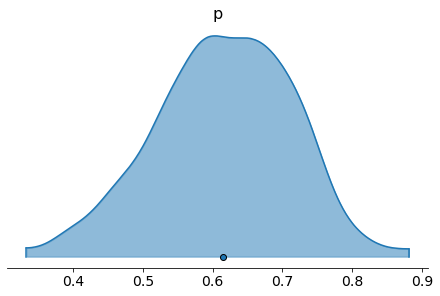

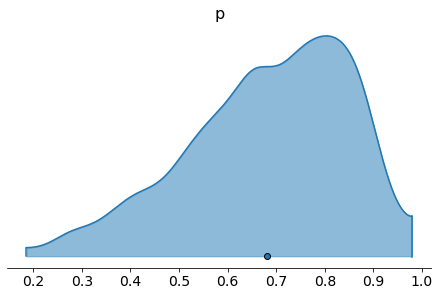

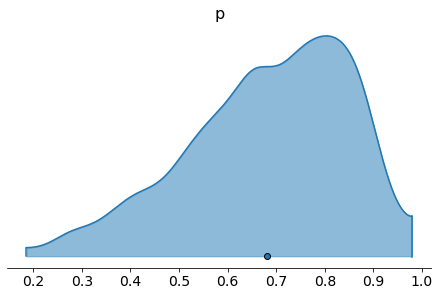

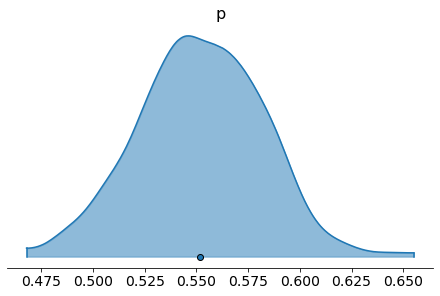

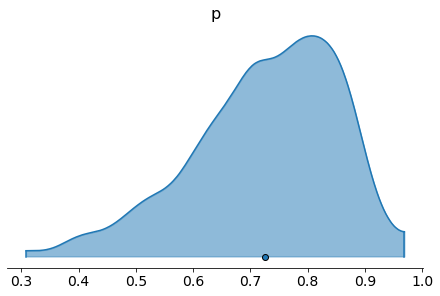

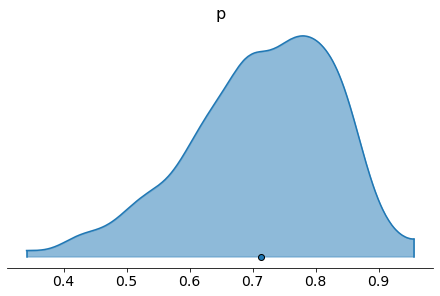

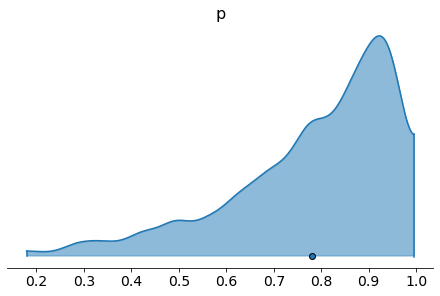

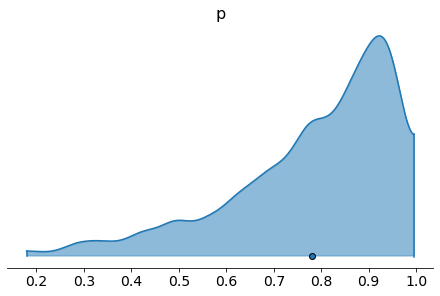

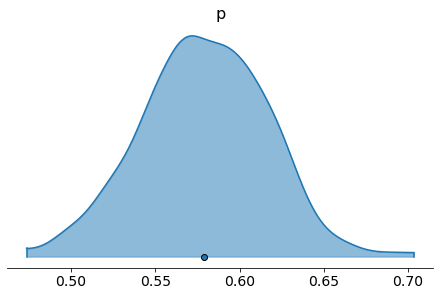

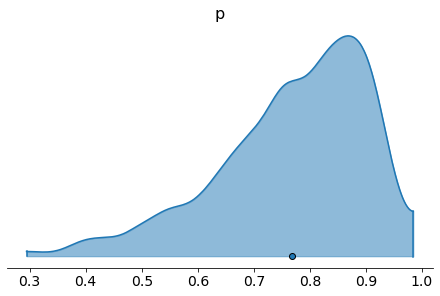

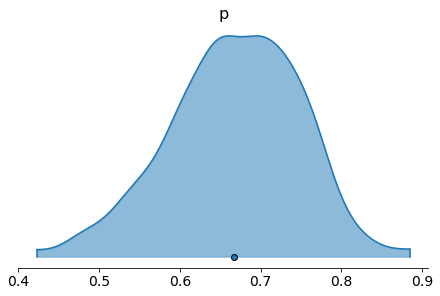

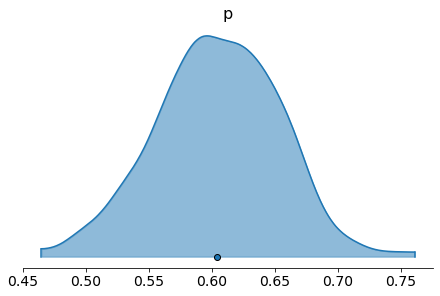

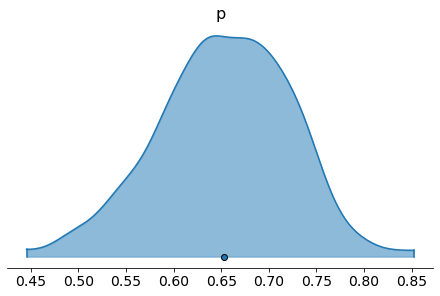

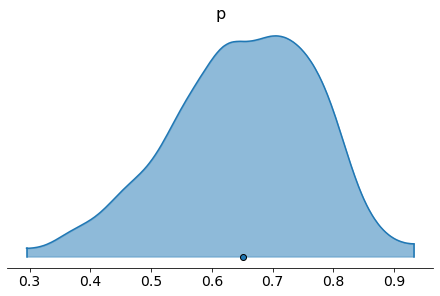

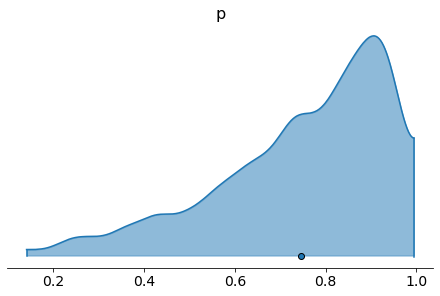

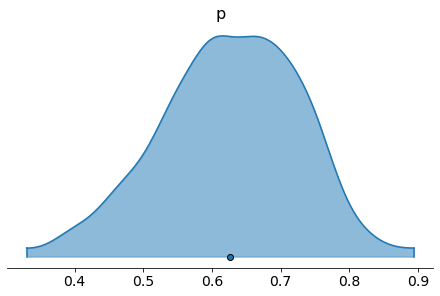

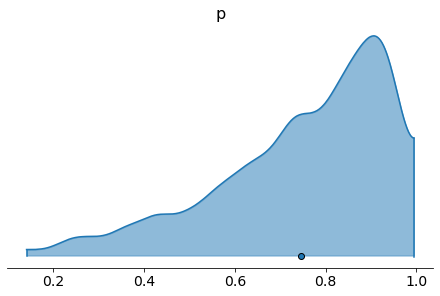

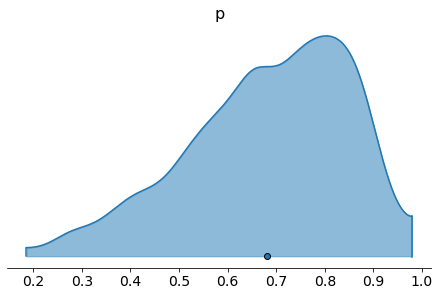

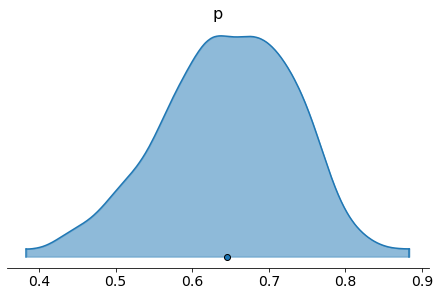

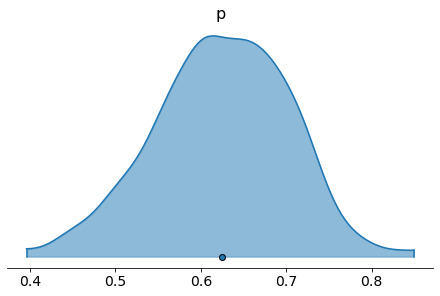

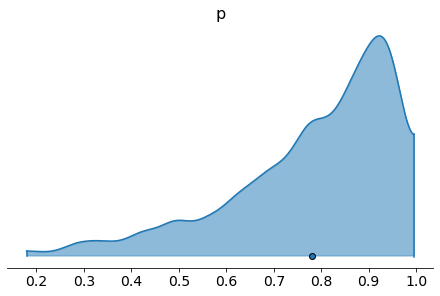

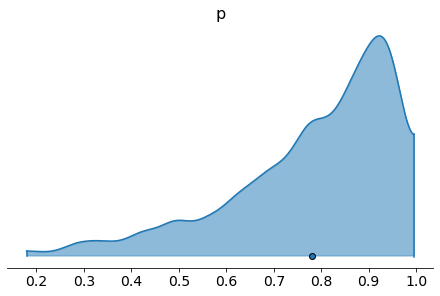

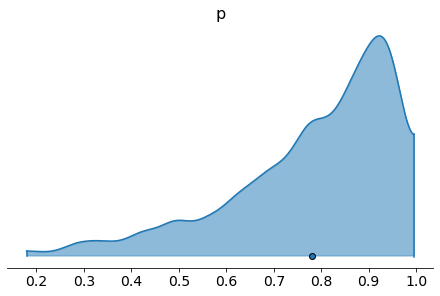

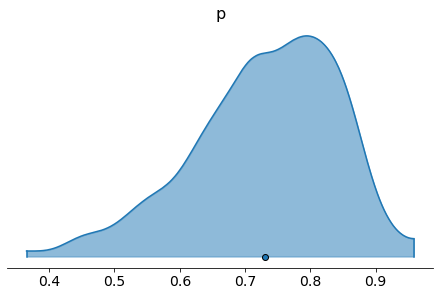

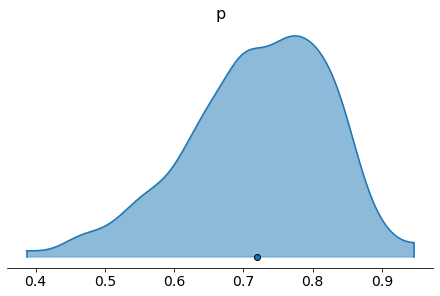

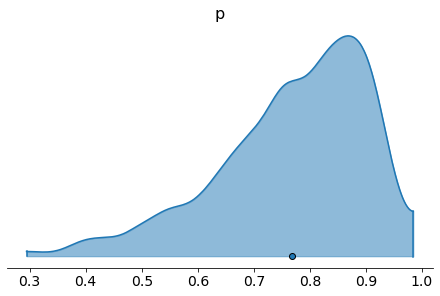

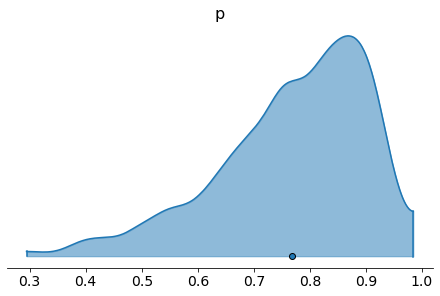

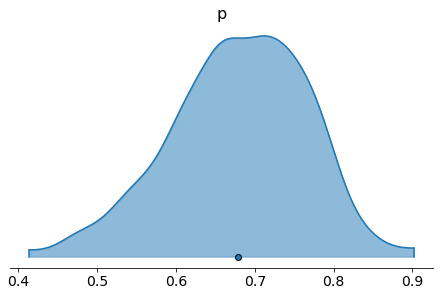

In [46]:
all_results = sim_many_experiments(5, true_probs_a=[0.6, 0.7], desired_cert_list=[0.8, 0.9, 0.95])

In [55]:
inbetween = lambda row: (row.hpdi_lower >= 0.5) & (row.hpdi_upper >= 0.5)
all_results["correct"] = all_results.apply(inbetween, axis=1)

In [56]:
all_results

,hpdi_lower,hpdi_upper,n,desired_certainty,true_prob_a,correct
0,0.507636,0.749899,22.0,0.80,0.6,True
1,0.020187,0.461826,2.0,0.80,0.6,False
2,0.520081,0.911663,5.0,0.80,0.6,True
3,0.500417,0.595975,278.0,0.90,0.6,True
4,0.517296,0.903757,10.0,0.90,0.6,True
5,0.526545,0.880907,13.0,0.90,0.6,True
6,0.528095,0.995937,4.0,0.90,0.6,True
7,0.500432,0.641900,177.0,0.95,0.6,True
8,0.501248,0.967761,8.0,0.95,0.6,True
9,0.506647,0.812375,32.0,0.95,0.6,True


In [57]:
all_results.hvplot(x="desired_certainty", y="true_prob_a", C="correct", kind="heatmap",reduce_function=np.mean)

:HeatMap   [desired_certainty,true_prob_a]   (correct)